# Visualization of bike trafic in Montpellier

## I) Montpellier_Biking presentation

This package contain a program which is a graphic interface to modelise bike traffic in Montpellier. 

Run program.py 

First step select the week you want to modelise.

Second step select days you want to modelise.

Then press make video ! 

It will create you a video by day.

![Guide](tuto.png)

## II) How works montpellier_biking's package

We use *osmnx* package to load Montpellier's map

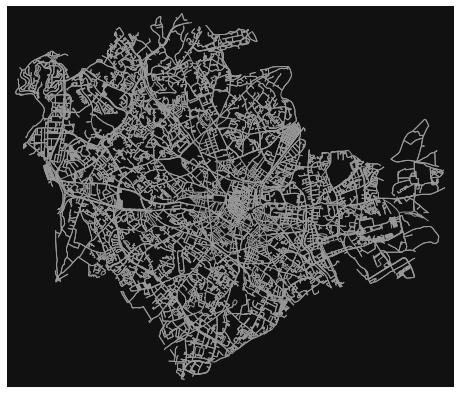

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [1]:
import osmnx as ox
G = ox.graph_from_place('Montpellier, France', 'bike')
ox.plot_graph(G,node_size=0)

### II-1 Data

We create a class Load_db to collect data of Montpellier Mediterannée Metropole's site. 
Data is number of bike passing threw *eco-counter* each day.


In [2]:
import montpellier_biking as mb
mb.io.Load_db.Load_db().set_df()

time to load graph:  86.93419241905212
C:\Users\Julie Alleau\Desktop\Projet_groupe\Montpellier_Biking\montpellier_biking\io\Load_db.py:130: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data_total['week'] = data_total.index.week


Albert 1er  Beracasa  Celleneuve  Delmas 1  Gerhardt  Lattes 1  \
2021-01-04        1089     808.0         510     381.0      1021     293.0   
2021-01-05        1182     909.0         566     601.0      1155     381.0   
2021-01-06        1267     959.0         543     679.0      1091     343.0   
2021-01-07        1153     837.0         511     606.0      1070     351.0   
2021-01-08        1182     873.0         541     650.0      1034     301.0   
...                ...       ...         ...       ...       ...       ...   
2021-03-31        1941    1245.0         750     726.0      1460     744.0   
2021-04-01        1917    1446.0         825     574.0      1458     729.0   
2021-04-02        1833    1715.0         759     811.0      1293     729.0   
2021-04-03        1056    1117.0         390     864.0       729     875.0   
2021-04-04         777    1172.0         447     694.0       465     737.0   

            Laverune  Vieille-Poste     mean  weekday  week  
2021-01-04       126            186  551.750        0     1  
2021-01-05       174            220  648.500        1     1  
2021-01-06       146            180  651.000        2     1  
2021-01-07       148            220  612.000        3     1  
2021-01-08       123            176  610.000        4     1  
...              ...            ...      ...      ...   ...  
2021-03-31       298            355  939.875        2    13  
2021-04-01       320            345  951.750        3    13  
2021-04-02       236            292  958.500        4    13  
2021-04-03       328            127  685.750        5    13  
2021-04-04       302            147  592.625        6    13  

[91 rows x 11 columns]

First we can see that the package osmnx take a lot of time to load Montpellier's graph, we tried to find a solution like save the graph, but methods proposed by the package don't work very well.

### II-2 Counters

We create a class named *Counter*. This class is the base of the model. It represent an eco-counter, basicly reprented by it's position on the graph, and the number of bike passed a day.

In this class we have important function like *generate_random_route*, *set_matrix* and also *list_for_ani*. They are made to simulate bike traffic. 
The point that we only have the number of bike passing, we don't know when, we don't were come from the bike and were does he go. So the way we found to simulate the flow is to make it totally random. The function  *generate_random_route* generate a random route passing threw a counter, set_matrix modelise the traffic for a day by generating random routes, the matrix is cut in 24 parts, for each hour of the day. Each hour passing is approximate from bike passing repartition of "Albert 1er" (Montpellier_totem gives more statement for the counter situated at "Albert 1er").
So each line of the created matrix is a list of node to plot at the time 'i'. We concatenate them for all counters and we got our simulation.


In [3]:
import numpy as np
from montpellier_biking.model.counters import Counter
def set_matrix(self, quality=2880):
        M1 = np.zeros((quality, quality))
        for j in range(24):
            i = 0
            while i <= Counter.bike_distribution[j]*self.bikes/100:
                route, lengh = Counter.generate_random_route(self)
                try:  # random bike passing time
                    random_pass = np.random.randint(low=120*j+lengh,
                                                    high=120*(j+1))
                    M1[random_pass-(lengh):random_pass+len(route)-lengh,
                       i+j*120] = route
                except Exception:  # last hour can't exceed 2880
                    random_pass = np.random.randint(low=min(len(route)+120*j,
                                                    120*(j+1)-1),
                                                    high=120*(j+1))
                    M1[random_pass-len(route):random_pass, i+j*120] = route
                i += 1
        #return sparse.csr_matrix(M1)  <- used in the package                                                                                                
        return M1

The disadvantage of this function is that it create a huge squared matrix, it size is the number of frame of our animation, moreover there is a lot of zeros because most of time there is no bike in the city, specially at the start and the end of the day.
For exemple we take a look at the matrix created for a day that passed 1500 bikes at Albert11er. That's why we return a sparse matrix.

In [4]:
import time
t = time.time()
Albert1er = mb.counters.Counter(coordinates=(43.61620945549243,
                                              3.874408006668091),
                                 node=ox.distance.get_nearest_node(G,
                                 (43.61620945549243, 3.874408006668091)),
                                 bikes=1500, name="Albert1er")
print(time.time()-t)

0.10779643058776855


57.60842418670654


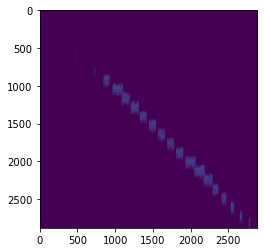

In [5]:
import matplotlib.pyplot as plt
t = time.time()
Matrix_exemple = set_matrix(Albert1er)
print(time.time()-t)
plt.imshow(Matrix_exemple)

We can see here that the matrix is mainly composed of zeros (purple part). So we return a sparse matrix to save memory. How much time to covert this matrix into a sparse martix ?

In [6]:
from scipy import sparse
t = time.time()
sparse.csr_matrix(Matrix_exemple)
print(time.time()-t)

0.2413315773010254


Not much time if we compare it to the time to create the matrix, and it saves a lot of memory! There is still a problematic, it takes much time to create matrix. Let's see if we can make it faster with the package *numba*. 

In [7]:
from numba import jit

route, lengh = Counter.generate_random_route(Albert1er) # fix the route to compare performances

@jit(nopython=True, parallel=True)
def set_matrix_numba(self, quality=2880):
        M1 = np.zeros((quality, quality))
        for j in range(24):
            i = 0
            while i <= Counter.bike_distribution[j]*self.bikes/100:
                
                try:  # random bike passing time
                    random_pass = np.random.randint(low=120*j+lengh,
                                                    high=120*(j+1))
                    M1[random_pass-(lengh):random_pass+len(route)-lengh,
                       i+j*120] = route
                except Exception:  # last hour can't exceed 2880
                    random_pass = np.random.randint(low=min(len(route)+120*j,
                                                    120*(j+1)-1),
                                                    high=120*(j+1))
                    M1[random_pass-len(route):random_pass, i+j*120] = route
                i += 1
        return sparse.csr_matrix(M1) 

In [8]:
t = time.time()
Matrix_exemple_numba = set_matrix_numba(Albert1er)
print(time.time()-t)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'Counter':[0m [1m[1mCannot determine Numba type of <class 'type'>[0m
[1m
File "<ipython-input-7-730ea7548467>", line 10:[0m
[1mdef set_matrix_numba(self, quality=2880):
    <source elided>
            i = 0
[1m            while i <= Counter.bike_distribution[j]*self.bikes/100:
[0m            [1m^[0m[0m
[0m

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'montpellier_biking.model.counters.Counter'>[0m


This package is only efficient for little function with for loops, it doesn't work for our function set_matrix because of the while loop, but maybe we can earn time on generating routes or converting node to scatter coordinates, they are little but we use them a lot of time (number of bikes, or number of frames).

In [9]:
    @jit(parallel=True)
    def route_to_scatter_numba(route):
        if len(route) != 0:
            scatter_list = []
            for j in range(len(route)):
                scatter = [G.nodes[route[j]]['x'], G.nodes[route[j]]['y']]
                scatter_list.append(scatter)
            return scatter_list

In [10]:
t=time.time()
for i in range(1000):
    route_to_scatter_numba(route)
print(time.time()-t)

<ipython-input-9-aefa9eb40518>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "route_to_scatter_numba" failed type inference due to: Untyped global name 'G': Cannot determine Numba type of <class 'networkx.classes.multidigraph.MultiDiGraph'>

File "<ipython-input-9-aefa9eb40518>", line 6:
def route_to_scatter_numba(route):
    <source elided>
        for j in range(len(route)):
            scatter = [G.nodes[route[j]]['x'], G.nodes[route[j]]['y']]
            ^

  @jit(parallel=True)
<ipython-input-9-aefa9eb40518>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "route_to_scatter_numba" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-9-aefa9eb40518>", line 4:
def route_to_scatter_numba(route):
    <source elided>
    if len(route) != 0:
        scatter_list = []
        ^

  @jit(parallel=True)
C:\

In [11]:
t=time.time()
for i in range(1000):
    Counter.route_to_scatter(route)
print(time.time()-t)

0.7131445407867432


Numba doesn't fit well with our Graph class, it take much more time. We won't use it in our package.

# A general presentation of the data :

In  this notebook we will presente in diffrent histograms the data provided to work with in order to give a more clear idea on bikes circulation flow in Montpellier city .

## The Data :

We will first import the packages needed to provide these charts ,as well as the data we will be working with .


In [12]:
#Importing the packages 
import pandas
import matplotlib.pyplot as plt

In [13]:
# Total on average per day 
# The sum of bikes in the whole city(all counters combined) for each day in a week(average in a year):
Monday = 1022+1273+772+769+1082+446+172 + 237
Tuesday=1139 + 1473+849+853+1261+481+236+267
Wednesday=1205 + 1547+761+825+1195+496+228+245
Thursday=1126+1497+825+870+1191+490+225+263
Friday=982 +1340+759+801+1047+445+152+209
Saturday =1009 +849 +499+617 +694 +484+248+90
Sunday = 1077 +652 +447+536+436 +516+303+90
x = [Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday]

In [14]:
x1 = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
# Average number per day for each counter :
x_Beracasa  =[1022,1139,1205,1126,982,1009,1077]
x_Albert_1er  =[1273,1473,1547,1497,1340,849,652]
x_Celleneuve   =[772,849,761,825,759,499,447]
x_Delmas = [769,853,825,870,801,617,536]
x_Gerhardt = [1082,1261,1195,1191,1047,694,436]
x_Lattes =[446,481,496,490,445,484,516]
x_Laverune = [172,236,228,225,152,248,303]
x_Vielle_poste = [237,267,245,263,209,90,90]

## The total average number of bikes in Montpellier city:

The first histogram represents the average number of bikes that circules per a day in a week in the city(yearly average for all counters combined)

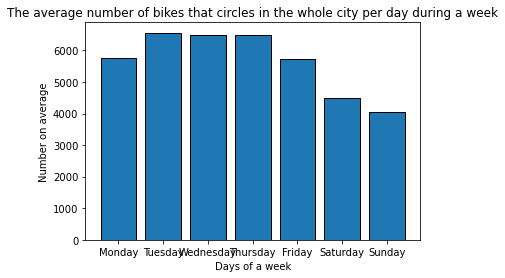

In [15]:
#Total average (all counters cobined):
plt.bar(x1,x, edgecolor = 'k')
plt.title('The average number of bikes that circles in the whole city per day during a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

## The average number of bikes per day in a week that passes by the counter in Beracasa:

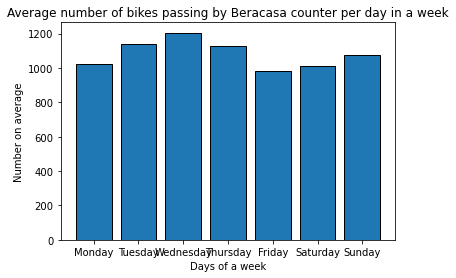

In [16]:
plt.bar(x1,x_Beracasa, edgecolor = 'k')
plt.title('Average number of bikes passing by Beracasa counter per day in a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

## The average number of bikes per day in a week that passes by the counter in Albert 1er: 

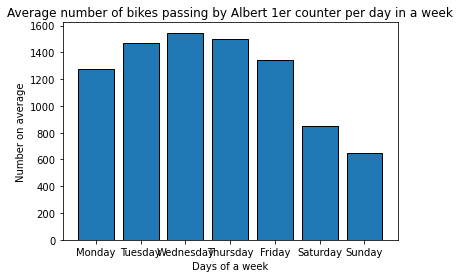

In [17]:

#Albert 1er counter 

plt.bar(x1,x_Albert_1er, edgecolor = 'k')
plt.title('Average number of bikes passing by Albert 1er counter per day in a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

## The average number of bikes per day in a week that passes by the counter in Celleneuve:

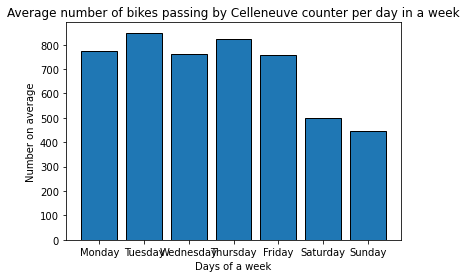

In [18]:
# Celleneuve counter

plt.bar(x1,x_Celleneuve, edgecolor = 'k')
plt.title('Average number of bikes passing by Celleneuve counter per day in a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

## The average number of bikes per day in a week that passes by the counter in Delmas:

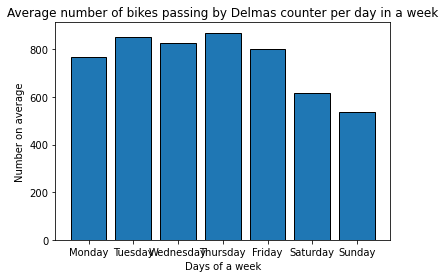

In [19]:
# Delmas counter 

plt.bar(x1,x_Delmas, edgecolor = 'k')
plt.title('Average number of bikes passing by Delmas counter per day in a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

## The average number of bikes per day in a week that passes by the counter in Gerhardt:

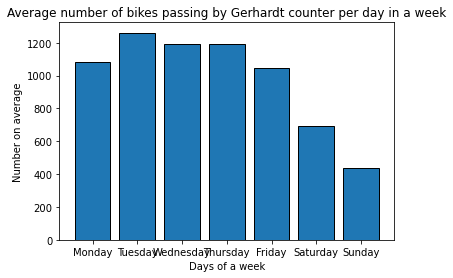

In [20]:
# Gerhardt counter 

plt.bar(x1,x_Gerhardt, edgecolor = 'k')
plt.title('Average number of bikes passing by Gerhardt counter per day in a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

## The average number of bikes per day in a week that passes by the counter in Lattes:

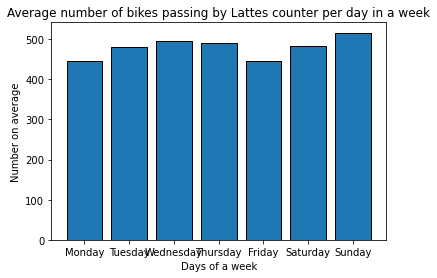

In [21]:
#Lattes counters

plt.bar(x1,x_Lattes, edgecolor = 'k')
plt.title('Average number of bikes passing by Lattes counter per day in a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

## The average number of bikes per day in a week that passes by the counter in Laverune:

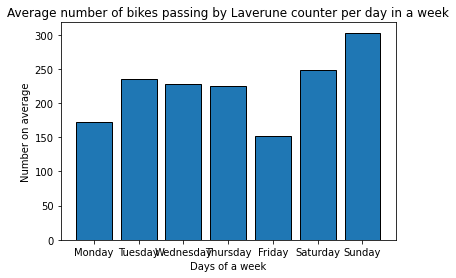

In [22]:
#Laverune counter

plt.bar(x1,x_Laverune, edgecolor = 'k')
plt.title('Average number of bikes passing by Laverune counter per day in a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

## The average number of bikes per day in a week that passes by the counter in Vielle-poste:

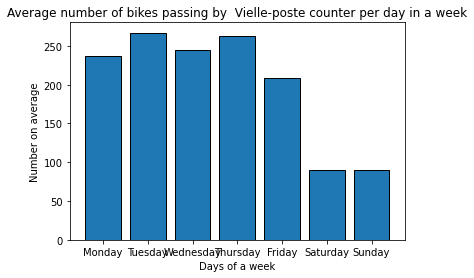

In [23]:
# Vielle-Poste counter :

plt.bar(x1,x_Vielle_poste, edgecolor = 'k')
plt.title('Average number of bikes passing by  Vielle-poste counter per day in a week')
plt.xlabel('Days of a week')
plt.ylabel('Number on average')
plt.show()

Widget : https://poncheele.github.io/Prediction_velo/ 